In [1]:
from extreme_classification.distributions import multivariate_logistic_distribution
from extreme_classification.extreme_dataset import ExtremeDataset
import numpy as np

In [2]:
x_1 = multivariate_logistic_distribution(1000, 2, 0.7)
x_2 = multivariate_logistic_distribution(1000, 2, 0.2)

y_1 = np.zeros(1000)
y_2 = np.ones(1000)

In [3]:
x = np.concatenate([x_1, x_2])
y = np.concatenate([y_1, y_2])

dataset = ExtremeDataset(x, y)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = plt.cm.viridis

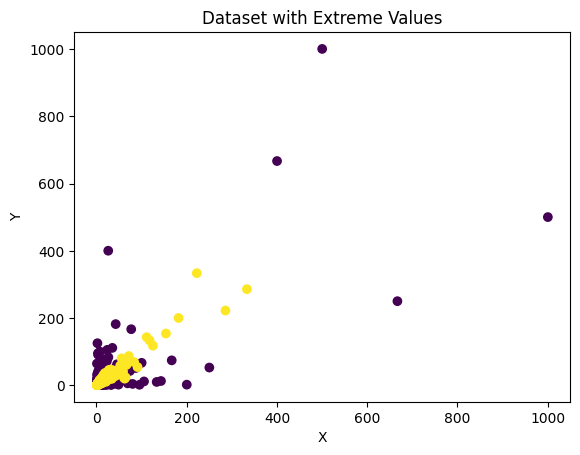

In [5]:
plt.scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.y, cmap=colormap)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dataset with Extreme Values')
plt.show()

In [6]:
x_extreme, y_extreme = dataset.get_extreme(50)

In [7]:
print(x_extreme.shape)

(50, 2)


In [8]:
boundary = dataset.get_boundary(50)

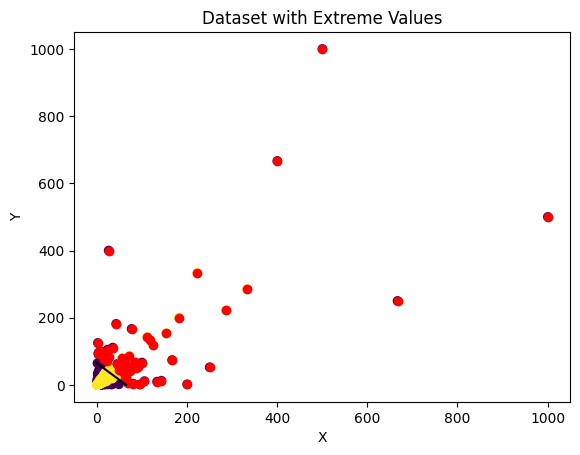

In [9]:
plt.scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.y, cmap=colormap)
plt.scatter(x_extreme[:, 0], x_extreme[:, 1], c="red")
plt.plot([0, boundary], [boundary, 0], c="black")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dataset with Extreme Values')
plt.show()


In [10]:
from extreme_classification.extreme_classifier import ExtremeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

def generate_data(n_samples, n_features, alphas):
    Xs = []
    ys = []
    for k, alpha in enumerate(alphas):
        X = multivariate_logistic_distribution(n_samples, n_features, alpha)
        y = np.zeros(n_samples) + k
        Xs.append(X)
        ys.append(y)

    X = np.concatenate(Xs)
    y = np.concatenate(ys)
    return X, y

X, y = generate_data(1000, 10, [0.3, 0.7])
dataset = ExtremeDataset(X, y)

X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.2, random_state=42)
train_dataset = ExtremeDataset(X_train, y_train, ranktransform=False)
test_dataset = ExtremeDataset(X_test, y_test, ranktransform=False)

base_classifier_extreme = KNeighborsClassifier(n_neighbors=5)
extreme_classifier = ExtremeClassifier(base_classifier_extreme, 2, 10)
standard_classifier = KNeighborsClassifier(n_neighbors=5)

classifier = KNeighborsClassifier(n_neighbors=5)

In [11]:
# train classifier
classifier.fit(train_dataset.X, train_dataset.y)

# extract extreme values from training set
k = int(np.sqrt(train_dataset.X.shape[0]))
print("Training extreme classifier with k = {}".format(k))
print("Boundary norm: {}".format(train_dataset.get_boundary(k)))
X_extreme, y_extreme = train_dataset.get_extreme(k)
X_standard, y_standard = train_dataset.get_standard(k)

# train extreme classifier
extreme_classifier.fit(X_extreme, y_extreme)

# train standard classifier
standard_classifier.fit(X_standard, y_standard)

Training extreme classifier with k = 40
Boundary norm: 154.78219567848618


KNeighborsClassifier()

In [12]:
from sklearn.metrics import accuracy_score

# evaluate classifiers on test set
print("Accuracy of classifier: {}".format(accuracy_score(test_dataset.y, classifier.predict(test_dataset.X))))

def evaluate_extreme_classifier(extreme_classifier, standard_classifier, dataset, boundary):
    extreme_X, extreme_y, standard_X, standard_y = dataset.split_extreme(boundary)

    extreme_predictions = extreme_classifier.predict(extreme_X)
    standard_predictions = standard_classifier.predict(standard_X)

    y = np.concatenate([extreme_y, standard_y])
    predictions = np.concatenate([extreme_predictions, standard_predictions])

    return accuracy_score(y, predictions)

boundary = train_dataset.get_boundary(k)
print("Accuracy of extreme classifier: {}".format(evaluate_extreme_classifier(extreme_classifier, standard_classifier, train_dataset, boundary)))

Accuracy of classifier: 0.7925
Accuracy of extreme classifier: 0.821875


In [13]:
# evaluate classifiers on extreme values of test set

extreme_X, extreme_y, _, _ = dataset.split_extreme(boundary)

print("Accuracy of extreme classifier on extreme values: {}".format(accuracy_score(extreme_y, extreme_classifier.predict(extreme_X))))
print("Accuracy of classifier on extreme values: {}".format(accuracy_score(extreme_y, classifier.predict(extreme_X))))

Accuracy of extreme classifier on extreme values: 0.7884615384615384
Accuracy of classifier on extreme values: 0.7884615384615384
